In [3]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib
matplotlib.rcParams['pdf.fonttype'] = 42
matplotlib.rcParams['ps.fonttype'] = 42
from cyvcf2 import VCF
from collections import defaultdict
import math
from scipy.stats.stats import pearsonr
from sklearn.metrics import r2_score
import seaborn as sns
from cyvcf2 import VCF
from statistics import mode
from collections import Counter
from functools import reduce

In [4]:
#### Read population and sample information ###
pops = ['AFR', 'EUR', 'EAS', 'AMR', 'SAS']

pedigree = pd.read_csv("/expanse/projects/gymreklab/helia/TR_1000G/1000G.ped", delim_whitespace=True)
pedigree = pedigree[['SampleID','Superpopulation']]
pop_dict = pedigree.groupby('Superpopulation')['SampleID'].apply(list).to_dict()

In [5]:


def compare(gts, imp):
    gts = gts.replace("(", "")
    gts = gts.replace(")", "")
    imp = imp.replace(")", "")
    imp = imp.replace("(", "")
    gts = gts.split(",")
    imp = imp.split(",")
    gts = [int(gt) for gt in gts]
    imp = [int(im) for im in imp]
    gts.sort()
    imp.sort() 
    if gts == imp:
        return 1
    if gts[0] in imp or gts[1] in imp:
        return 0.5
    return 0


def calc_concordance(imputed_df, genotype_df):
    concordance = []
    for i in range(len(imputed_df)):
        n = 100
        gts = list(genotype_df.iloc[i])
        imputes = list(imputed_df.iloc[i])
        sum_11 = 0
        if gts[0] != imputes[0]:
            print("Positions are not match", gts[0])
        for j in range(1,n+1):
            if (type(gts[j]) == float and math.isnan(gts[j])) or (type(imputes[j]) == float and math.isnan(imputes[j])):
                n -= 1
                continue
            sum_11 += compare(gts[j],imputes[j])
        concordance.append([chrom,gts[0],sum_11/n])
    return concordance

def calc_r2(imputed_df, genotype_df):
    correlation = []
    for i in range(len(imputed_df)):
        n = 100
        gts = list(genotype_df.iloc[i])
        imputes = list(imputed_df.iloc[i])
        sum_11 = 0
        if gts[0] != imputes[0]:
            print("Positions are not match", gts[0])
            
        gts_vector = []
        imputed_vector = []
                
        for j in range(1,n+1):
            print(j)
            if (type(gts[j]) == float and math.isnan(gts[j])) or (type(imputes[j]) == float and math.isnan(imputes[j])):
                continue
            vec = gts[j].replace("(","").replace(")","").split(",")
            gts_vector.extend([int(x) for x in vec])
            
            vec = imputes[j].replace("(","").replace(")","").split(",")
            imputed_vector.extend([int(x) for x in vec])
        
        pearson = pearsonr(gts_vector, imputed_vector)[0]
        if np.isnan(pearson):
            correlation.append((gts[0], r2_score(gts_vector, imputed_vector)))
        else:
            correlation.append((gts[0], pearson**2))
    return correlation


chrom=21
concordance = []
r2 = []
for pop in pops:
    imputed = pd.read_csv(f"/expanse/projects/gymreklab/helia/ensembl/1000Genomes-TR-Analysis/phasing/validation/diff_{pop}/{chrom}/imputed.csv", sep = ",")
    genotypes = pd.read_csv(f"/expanse/projects/gymreklab/helia/ensembl/1000Genomes-TR-Analysis/phasing/validation/diff_{pop}/{chrom}/genotypes.csv", sep = ",")
    concordance.append(calc_concordance(imputed, genotypes))
    #r2.append(calc_r2(imputed, genotypes))
        


In [4]:
for i in range(5):
    pop = pops[i]
    print(f"{pop}", np.array([x[2] for x in concordance[i]]).mean())


AFR 0.9854483928470508
EUR 0.991344701261492
EAS 0.9881810581716524
AMR 0.9916744762716678
SAS 0.9878560733324793


In [6]:
def common_alleles(afreqs):
    if afreqs == ".":
        return np.nan
    afreqs = afreqs.split(",")
    cnt = 0
    for afreq in afreqs:
        if float(afreq.split(":")[1]) > 0.01:
            cnt += 1   
    return cnt

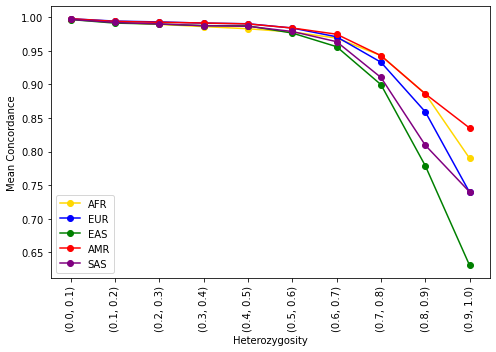

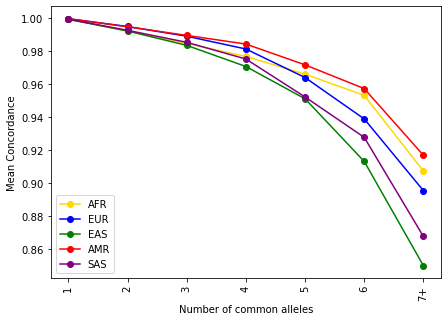

In [13]:
### Concordance vs heterozygosity plot ###

popcolors = {}
popcolors["AFR"] = "gold"
popcolors["AMR"] = "red"
popcolors["EAS"] = "green"
popcolors["EUR"] = "blue"
popcolors["SAS"] = "purple"

fig, ax = plt.subplots(figsize=(7, 5))
fig2, ax2 = plt.subplots(figsize=(7, 5))
keys = []
for i in range(10):
    keys.append((i/10,(i+1)/10))
for i in range(len(pops)):
    pop = pops[i]
    
    stats = pd.read_csv(f"/expanse/projects/gymreklab/helia/ensembl/experiments/allele_freq/freqs/freqs_chr21_{pop}.tab", 
                        sep = "\t")
    stats['chrom'] = stats['chrom'].astype(str)


    df = pd.DataFrame(concordance[i],columns =['chrom', 'start', 'score'])
    df['chrom'] = 'chr' + df['chrom'].astype(str)
    stats['common_alleles'] = stats.apply(lambda x: common_alleles(x['afreq-1']), axis = 1)
    stats_scores = pd.merge(stats, df, on = ['chrom','start'])
    
    stats_scores_grouped = stats_scores.groupby("common_alleles", as_index=False).agg({'score': np.mean})
    plus_7 = np.mean(stats_scores[stats_scores['common_alleles'] > 6]['score'])
    stats_scores_grouped = stats_scores_grouped[stats_scores_grouped['common_alleles'] < 7]
    stats_scores_grouped.loc[len(stats_scores_grouped.index)] = [7, plus_7] 
    het_dict = {}
    for i in range(10):
        het_dict[i] = []
        
    for index,row in stats_scores.iterrows():
        if len(row['afreq-1'].split(",")) == 1:
            continue
        het_dict[int(row['het-1'] * 10)].append(row['score'])
        
    for key in het_dict:
        het_dict[key] = np.mean(het_dict[key])
           
    ax.plot(het_dict.keys(), het_dict.values(), marker= "o", label = pop, color = popcolors[pop])

    ax2.plot(stats_scores_grouped.common_alleles, stats_scores_grouped.score, 
         marker= "o", label = pop,  color = popcolors[pop])
    
ax2.xaxis.set_ticks(np.arange(1, 8, 1))
ax2.set_xticklabels([str(x) for x in np.arange(1, 7, 1)] + ["7+"] ,rotation='vertical')
ax2.set_ylabel("Mean Concordance")
ax2.set_xlabel("Number of common alleles")
ax2.legend(loc="lower left")  
fig2.savefig("Heterozygosity_vs_number_of_alleles.pdf", dpi=1200)


ax.xaxis.set_ticks(np.arange(0, 10, 1))
ax.set_xticklabels(keys,rotation='vertical')
ax.set_xlabel("Heterozygosity")
ax.set_ylabel("Mean Concordance")
ax.legend(loc="lower left")  
fig.tight_layout()
plt.savefig("Heterozygosity_vs_score.pdf", dpi=1200)

In [68]:
#### Compare vs naive model ####

pop_dfs = []
for pop in pops:
    print(pop)
    diff_per_record = []
    pop_vcf = VCF("/expanse/projects/gymreklab/helia/ensembl/1000Genomes-TR-Analysis/phasing/filtered_calls/chr21_polymorphic.vcf.gz", 
                  samples = pop_dict[pop])
    for record in pop_vcf:
        alleles = [record.REF] + record.ALT
        gts = [sorted(gt[0:2]) for gt in record.genotypes if len(gt) == 3]
        gts = [(gt[0], gt[1]) for gt in gts]
        if len(gts) == 0:
            continue
        most_common_gt = Counter(gts).most_common(1)[0][0]
        diff_bp = (len(alleles[most_common_gt[0]]) - len(record.REF), \
                   len(alleles[most_common_gt[1]]) - len(record.REF))
        
        diff_per_record.append([record.POS, record.INFO['RU'], diff_bp])
    
    pop_df = pd.DataFrame(diff_per_record, columns = ['pos' , 'motif', f'{pop}_GT'])
    pop_dfs.append(pop_df)
    
ALL = reduce(lambda  left,right: pd.merge(left, right, on=['pos','motif'],
                                          how='outer'), pop_dfs)

AFR
EUR
EAS
AMR
SAS


In [57]:
chrom = 21
concordances = []
for pop in pops:
    genotypes = pd.read_csv(f"/expanse/projects/gymreklab/helia/ensembl/1000Genomes-TR-Analysis/phasing/validation/diff_{pop}/{chrom}/genotypes.csv", sep = ",")
    concordance = []
    for i in range(len(genotypes)):
        n = 100
        gts = list(genotypes.iloc[i])
        sum_11 = 0
        most_repeated_gt = ALL[ALL['pos'] == gts[0]][f'{pop}_GT'].iloc[0]
        for j in range(1,n+1):
            if (type(gts[j]) == float and math.isnan(gts[j])) or (type(most_repeated_gt) == float and math.isnan(most_repeated_gt)):
                n -= 1
                continue
            sum_11 += compare(gts[j],str(most_repeated_gt))
        concordance.append([chrom,gts[0],sum_11/n])
    concordances.append(concordance)

In [58]:
for i in range(5):
    pop = pops[i]
    print(f"{pop}", np.array([x[2] for x in concordances[i]]).mean())

AFR 0.8434879591375926
EUR 0.8817398655784738
EAS 0.885962963803901
AMR 0.8747928409070183
SAS 0.8771565357213926
